<a href="https://colab.research.google.com/github/Tonioord/ChallengeTelecomX2/blob/main/CTX2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
import json
import datetime
import chardet
from scipy.stats import pointbiserialr,chi2_contingency
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Balanceo de clases
from imblearn.under_sampling import RandomUnderSampler

# Preprocesamiento y selección de modelo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Métricas de evaluación
from sklearn.metrics import classification_report, accuracy_score

#Preparación de datos


In [12]:
import pandas as pd

url = "https://raw.githubusercontent.com/Tonioord/ChallengeTelecomX2/main/datos_tratados.csv"

df = pd.read_csv(url)

df.head(5)

,ID_Cliente,Desercion,Genero,Adulto_Mayor,Pareja,Dependientes,Antiguedad_Meses,Servicio_Telefono,Lineas_Multiples,Servicio_Internet,...,Soporte_Tecnico,TV_Streaming,Peliculas_Streaming,Tipo_Contrato,Facturacion_Sin_Papel,Metodo_Pago,Cargo_Mensual,Cargo_Total,Desercion_Binaria,Cuentas_Diarias
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,0.0,2.19
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,0.0,2.00
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,1.0,2.46
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,1.0,3.27
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,1.0,2.80


In [13]:
df = pd.read_csv('datos_tratados.csv')

# Definir df_pre eliminando las columnas no deseadas
# Eliminamos el ID y la versión de texto de la deserción
columnas_a_eliminar = ['ID_Cliente', 'Desercion']
df_pre = df.drop(columns=[col for col in columnas_a_eliminar if col in df.columns])

# Aplicar One-Hot Encoding
# drop_first=True evita la redundancia de datos
df_OHE = pd.get_dummies(df_pre, drop_first=True)

# 4. Verificar resultados
print(f"Nuevas dimensiones: {df_OHE.shape}")
df_OHE.head()

Nuevas dimensiones: (7267, 32)


,Adulto_Mayor,Antiguedad_Meses,Cargo_Mensual,Cargo_Total,Desercion_Binaria,Cuentas_Diarias,Genero_Male,Pareja_Yes,Dependientes_Yes,Servicio_Telefono_Yes,...,TV_Streaming_No internet service,TV_Streaming_Yes,Peliculas_Streaming_No internet service,Peliculas_Streaming_Yes,Tipo_Contrato_One year,Tipo_Contrato_Two year,Facturacion_Sin_Papel_Yes,Metodo_Pago_Credit card (automatic),Metodo_Pago_Electronic check,Metodo_Pago_Mailed check
0,0,9,65.6,593.30,0.0,2.19,False,True,True,True,...,False,True,False,False,True,False,True,False,False,True
1,0,9,59.9,542.40,0.0,2.00,True,False,False,True,...,False,False,False,True,False,False,False,False,False,True
2,0,4,73.9,280.85,1.0,2.46,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
3,1,13,98.0,1237.85,1.0,3.27,True,True,False,True,...,False,True,False,True,False,False,True,False,True,False
4,1,3,83.9,267.40,1.0,2.80,False,True,False,True,...,False,True,False,False,False,False,True,False,False,True


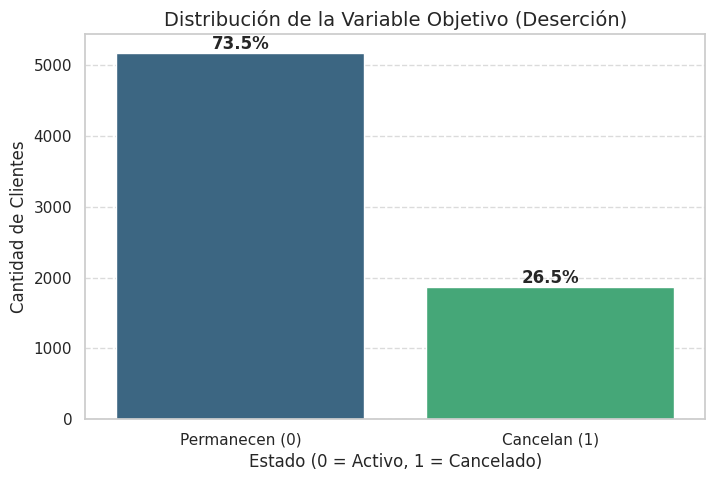

In [14]:
conteos = df['Desercion_Binaria'].value_counts()
proporciones = df['Desercion_Binaria'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 5))

sns.barplot(
    x=conteos.index,
    y=conteos.values,
    hue=conteos.index,
    palette='viridis',
    legend=False
)

for i, valor in enumerate(conteos.values):
    plt.text(i, valor + 50, f'{proporciones.values[i]:.1f}%',
             ha='center', fontsize=12, fontweight='bold')

plt.title('Distribución de la Variable Objetivo (Deserción)', fontsize=14)
plt.xlabel('Estado (0 = Activo, 1 = Cancelado)', fontsize=12)
plt.ylabel('Cantidad de Clientes', fontsize=12)
plt.xticks([0, 1], ['Permanecen (0)', 'Cancelan (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

##Balanceo de Datos

Estrategias de Balanceo de Datos:

Dado que nuestro dataset presenta un desbalance moderado (73% Activos vs 26% Cancelados), los modelos de Machine Learning pueden volverse "perezosos" y aprender a predecir siempre la clase mayoritaria. Para corregir esto, aplicamos tres técnicas:

1. Oversampling (SMOTE)
¿Qué es?: Aumenta el número de ejemplos de la clase minoritaria (clientes que cancelaron).

¿Cómo funciona?: No solo duplica filas, sino que utiliza el algoritmo SMOTE (Synthetic Minority Over-sampling Technique) para crear "ejemplos sintéticos" nuevos. Mira los clientes que cancelaron y crea datos nuevos que se sitúan matemáticamente entre ellos.

Ventaja: No perdemos información, ya que conservamos todos los datos de los clientes que se quedaron.

2. Undersampling (Muestreo bajo)
¿Qué es?: Reduce el número de ejemplos de la clase mayoritaria (clientes activos).

¿Cómo funciona?: Elimina aleatoriamente registros de la clase mayoritaria hasta que el número de clientes activos sea igual al de clientes que cancelaron.

Ventaja: El modelo se entrena mucho más rápido y es menos propenso a memorizar datos específicos (overfitting).

3. Estrategia Combinada (Enfoque Híbrido)
En lugar de elegir una, usamos lo mejor de ambos mundos:

Aplicamos SMOTE para subir la clase minoritaria a un nivel intermedio (sin "inventar" demasiados datos).

Aplicamos Undersampling para reducir un poco la clase mayoritaria hasta alcanzar el equilibrio.

¿Por qué usar la combinada en este proyecto?

Evita el sesgo: Al tener clases 50/50, obligamos al modelo a darle la misma importancia a los que cancelan que a los que se quedan.

Mantiene la calidad: No perdemos tanta información real como en el Undersampling puro, ni dependemos de demasiados datos sintéticos como en el Oversampling puro.

Mejor Recall: Esta técnica suele ser la más efectiva para detectar el Churn (cancelación), que es el objetivo principal de negocio.


En la preparación de los datos para el modelo, se han excluido las columnas Desercion y Desercion_Binaria del conjunto de características ($X$) por los siguientes motivos:

Evitar el "Data Leakage" (Fuga de Datos): La columna Desercion_Binaria es nuestra variable objetivo (lo que el modelo debe aprender a predecir). Si la incluimos en las preguntas ($X$), el modelo simplemente "copiaría" la respuesta en lugar de aprender los patrones de comportamiento de los clientes.

Eliminación de Redundancia: La columna Desercion contiene la misma información que Desercion_Binaria pero en formato de texto ("Yes"/"No"). Al ser información duplicada y no numérica, no aporta valor al algoritmo y se elimina para simplificar el dataset.

Separación de Roles: En Machine Learning, dividimos los datos en Características ($X$), que son las causas (contrato, cargos, servicios), y la Etiqueta ($y$), que es el efecto o resultado que queremos pronosticar.


In [15]:
#Despues de revisar los cambios y analizar que hay que balancear los datos, repito los pasos para evitar errores
df = pd.read_csv('datos_tratados.csv')

# Eliminamos filas donde la variable objetivo sea NaN para evitar errores
df = df.dropna(subset=['Desercion_Binaria'])

# Preparación de variables (X y y)
# Eliminamos identificadores y la versión de texto de la deserción
X = df.drop(columns=['ID_Cliente', 'Desercion', 'Desercion_Binaria'], errors='ignore')
y = df['Desercion_Binaria']

# Convertimos variables categóricas a numéricas (One-Hot Encoding)
X = pd.get_dummies(X, drop_first=True)

# Rellenamos nulos en las características con la mediana (requerido por SMOTE)
X = X.fillna(X.median())

print(f"Distribución original: {Counter(y)}")

# --- APLICACIÓN DE ESTRATEGIA HÍBRIDA ---

# Paso A: SMOTE (Oversampling)
# Aumentamos la clase minoritaria (1) para que sea el 50% del tamaño de la clase mayoritaria (0)
over = SMOTE(sampling_strategy=0.5, random_state=42)
X_temp, y_temp = over.fit_resample(X, y)
print(f"Después de SMOTE (Paso 1): {Counter(y_temp)}")

# Paso B: Random Undersampling
# Reducimos la clase mayoritaria (0) para que iguale a la clase minoritaria (1)
under = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_final, y_final = under.fit_resample(X_temp, y_temp)

print(f"Distribución Final (Híbrida): {Counter(y_final)}")

#Crear el DataFrame final balanceado
df_balanceado = pd.concat([pd.DataFrame(X_final), pd.Series(y_final, name='Desercion_Binaria')], axis=1)
df_balanceado.head()

Distribución original: Counter({0.0: 5174, 1.0: 1869})
Después de SMOTE (Paso 1): Counter({0.0: 5174, 1.0: 2587})
Distribución Final (Híbrida): Counter({0.0: 2587, 1.0: 2587})


,Adulto_Mayor,Antiguedad_Meses,Cargo_Mensual,Cargo_Total,Cuentas_Diarias,Genero_Male,Pareja_Yes,Dependientes_Yes,Servicio_Telefono_Yes,Lineas_Multiples_No phone service,...,TV_Streaming_Yes,Peliculas_Streaming_No internet service,Peliculas_Streaming_Yes,Tipo_Contrato_One year,Tipo_Contrato_Two year,Facturacion_Sin_Papel_Yes,Metodo_Pago_Credit card (automatic),Metodo_Pago_Electronic check,Metodo_Pago_Mailed check,Desercion_Binaria
2145,0,13,19.75,246.70,0.66,False,True,True,True,False,...,False,True,False,False,True,True,False,False,False,0.0
2720,0,70,113.05,7869.05,3.77,False,True,True,True,False,...,True,False,True,False,True,True,True,False,False,0.0
1680,1,67,101.40,6841.05,3.38,True,False,False,True,False,...,True,False,True,False,False,True,True,False,False,0.0
6028,0,61,106.45,6300.15,3.55,True,False,False,True,False,...,True,False,True,False,False,True,False,True,False,0.0
6822,0,55,90.15,4916.95,3.01,False,True,False,True,False,...,True,False,True,True,False,True,False,True,False,0.0


Para que un análisis sea robusto y compatible con cualquier modelo, lo ideal es aplicar una Estandarización (StandardScaler), que transforma los datos para que tengan media 0 y desviación estándar 1.

In [16]:
# 1. Definir las columnas numéricas continuas (las que tienen rangos muy distintos)
cols_continuas = ['Antiguedad_Meses', 'Cargo_Mensual', 'Cargo_Total', 'Cuentas_Diarias']

# 2. Inicializar el escalador
scaler = StandardScaler()

# 3. Crear el DataFrame final escalado
# Hacemos una copia de df_balanceado para no alterar los datos originales
df_final_escalado = df_balanceado.copy()

# Aplicar el escalamiento solo a las columnas continuas
df_final_escalado[cols_continuas] = scaler.fit_transform(df_balanceado[cols_continuas])

print(f"Dimensiones finales: {df_final_escalado.shape}")
print("\nDataframe con datos balanceados y escalados:")
df_final_escalado.head()

Dimensiones finales: (5174, 32)

Dataframe con datos balanceados y escalados:


,Adulto_Mayor,Antiguedad_Meses,Cargo_Mensual,Cargo_Total,Cuentas_Diarias,Genero_Male,Pareja_Yes,Dependientes_Yes,Servicio_Telefono_Yes,Lineas_Multiples_No phone service,...,TV_Streaming_Yes,Peliculas_Streaming_No internet service,Peliculas_Streaming_Yes,Tipo_Contrato_One year,Tipo_Contrato_Two year,Facturacion_Sin_Papel_Yes,Metodo_Pago_Credit card (automatic),Metodo_Pago_Electronic check,Metodo_Pago_Mailed check,Desercion_Binaria
2145,0,-0.619021,-1.694427,-0.828578,-1.692500,False,True,True,True,False,...,False,True,False,False,True,True,False,False,False,0.0
2720,0,1.751372,1.562787,2.624700,1.564378,False,True,True,True,False,...,True,False,True,False,True,True,True,False,False,0.0
1680,1,1.626614,1.156072,2.158968,1.155959,True,False,False,True,False,...,True,False,True,False,False,True,True,False,False,0.0
6028,0,1.377099,1.332374,1.913915,1.333988,True,False,False,True,False,...,True,False,True,False,False,True,False,True,False,0.0
6822,0,1.127584,0.763321,1.287262,0.768485,False,True,False,True,False,...,True,False,True,True,False,True,False,True,False,0.0


##Análisis de Correlación:

Análisis de Correlación: Es fundamental para entender qué factores están impulsando a los clientes a cancelar el servicio. Utilizaremos el coeficiente de correlación de Pearson (que va de -1 a 1) para identificar estas relaciones.

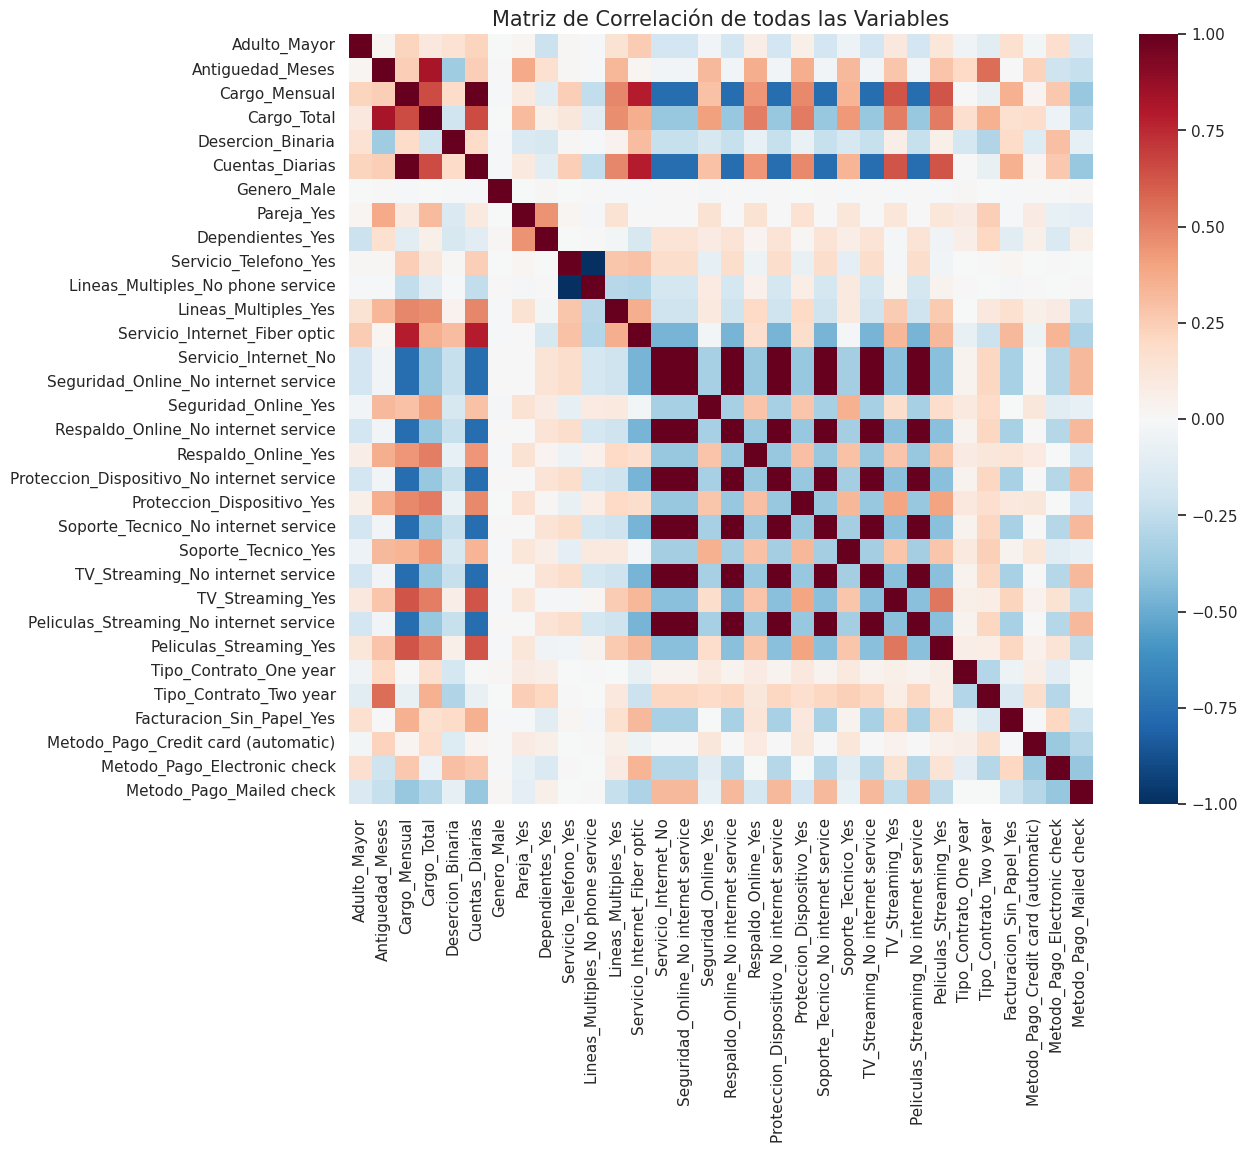

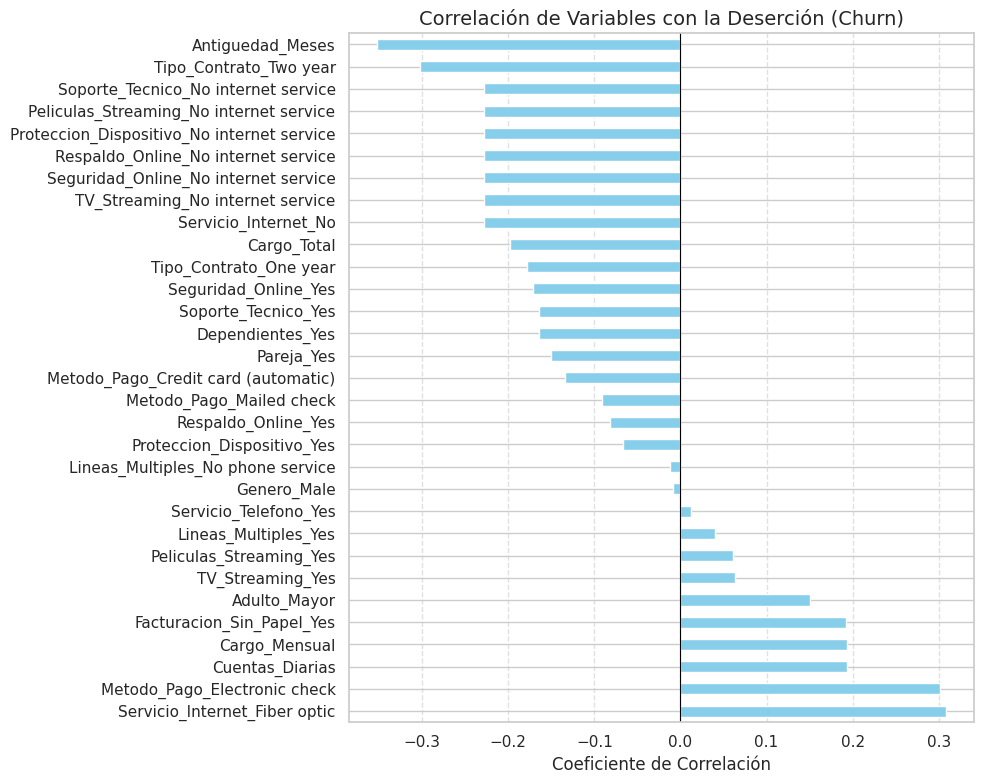

In [17]:

# 1. Preparar los datos (usando el DataFrame que ya tiene Encoding)
# Si no lo tienes definido, lo recreamos rápidamente:
df = pd.read_csv('datos_tratados.csv')
df_limpio = df.drop(columns=['ID_Cliente', 'Desercion'], errors='ignore').dropna(subset=['Desercion_Binaria'])
df_corr = pd.get_dummies(df_limpio, drop_first=True)

# 2. Calcular la correlación específicamente con la variable objetivo
correlaciones = df_corr.corr()['Desercion_Binaria'].sort_values(ascending=False)

# 3. Visualización: Mapa de Calor (Heatmap)
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr.corr(), annot=False, cmap='RdBu_r', center=0)
plt.title('Matriz de Correlación de todas las Variables', fontsize=15)
plt.show()

# 4. Visualización: Variables que más afectan la deserción
plt.figure(figsize=(10, 8))
correlaciones.drop('Desercion_Binaria').plot(kind='barh', color='skyblue')
plt.title('Correlación de Variables con la Deserción (Churn)', fontsize=14)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.xlabel('Coeficiente de Correlación')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Resumen del Análisis de Correlación:

El coeficiente de correlación (de -1 a 1) nos indica la fuerza y dirección de la relación entre las características de los clientes y la probabilidad de que cancelen su servicio (Desercion_Binaria).

1. Factores de Riesgo (Correlación Positiva - Rojo)
Estos elementos "empujan" al cliente hacia la cancelación. Mientras más presente está la variable, más sube el riesgo:

Servicio de Fibra Óptica (~0.31): Es el indicador de riesgo más alto. Esto sugiere que los clientes con fibra podrían estar insatisfechos con el precio o haber experimentado problemas técnicos recurrentes en comparación con DSL.

Pago con Cheque Electrónico (~0.30): Existe una relación muy fuerte entre este método de pago y la fuga de clientes. Podría estar asociado a clientes que no quieren domiciliar sus pagos porque no planean quedarse a largo plazo.

Cargos Mensuales y Diarios (~0.19): Como era de esperar, cuanto más cara es la factura mensual, más sensible es el cliente a buscar otras opciones económicas.

Clientes Senior (Adulto Mayor) (~0.15): Los adultos mayores muestran una tendencia ligeramente superior a cancelar el servicio en comparación con los clientes jóvenes.

2. Factores de Retención (Correlación Negativa - Azul)
Estos elementos actúan como un "ancla". Su presencia disminuye significativamente la probabilidad de que el cliente se vaya:

Antigüedad en Meses (-0.35): Es el factor protector más fuerte. Los clientes que superan los primeros meses críticos tienden a volverse leales. La curva de aprendizaje y la costumbre actúan a favor de la empresa.

Contratos a Largo Plazo (1 y 2 años) (-0.30): Los clientes con contratos anuales o bianuales tienen una tasa de deserción mucho menor. La estabilidad contractual es la mejor herramienta de retención.

Sin Servicio de Internet (-0.23): Los clientes que solo tienen contratado el servicio de teléfono son mucho más estables. Esto puede deberse a que son servicios menos costosos y con menos fallos técnicos reportados.

Servicios de Valor Añadido (Seguridad Online, Soporte Técnico): Los clientes que contratan seguridad o soporte muestran menor tendencia a irse, lo que indica que estos servicios generan una percepción de valor y dependencia positiva.

Para analizar el abandono de clientes (Churn), lo ideal es estructurar un análisis bivariado que cruce cada variable predictora con la variable objetivo (Cancelación).

1. Gasto mensual: Las facturas altas o los aumentos repentinos suelen detonar cancelaciones.

2. Tipo de contrato: Los contratos "Mes a mes" tienen mucha mayor probabilidad de abandono que los anuales.

3. Días de retraso en pagos: Un comportamiento de pago irregular suele preceder a la baja del servicio.

4. Contactos con soporte técnico: Múltiples reportes de fallas indican fricción y mala experiencia.

5. Días desde el último uso: La inactividad prolongada (caída en el engagement) es un síntoma claro.

6. Quejas no resueltas: Tickets abiertos o insatisfacción documentada.

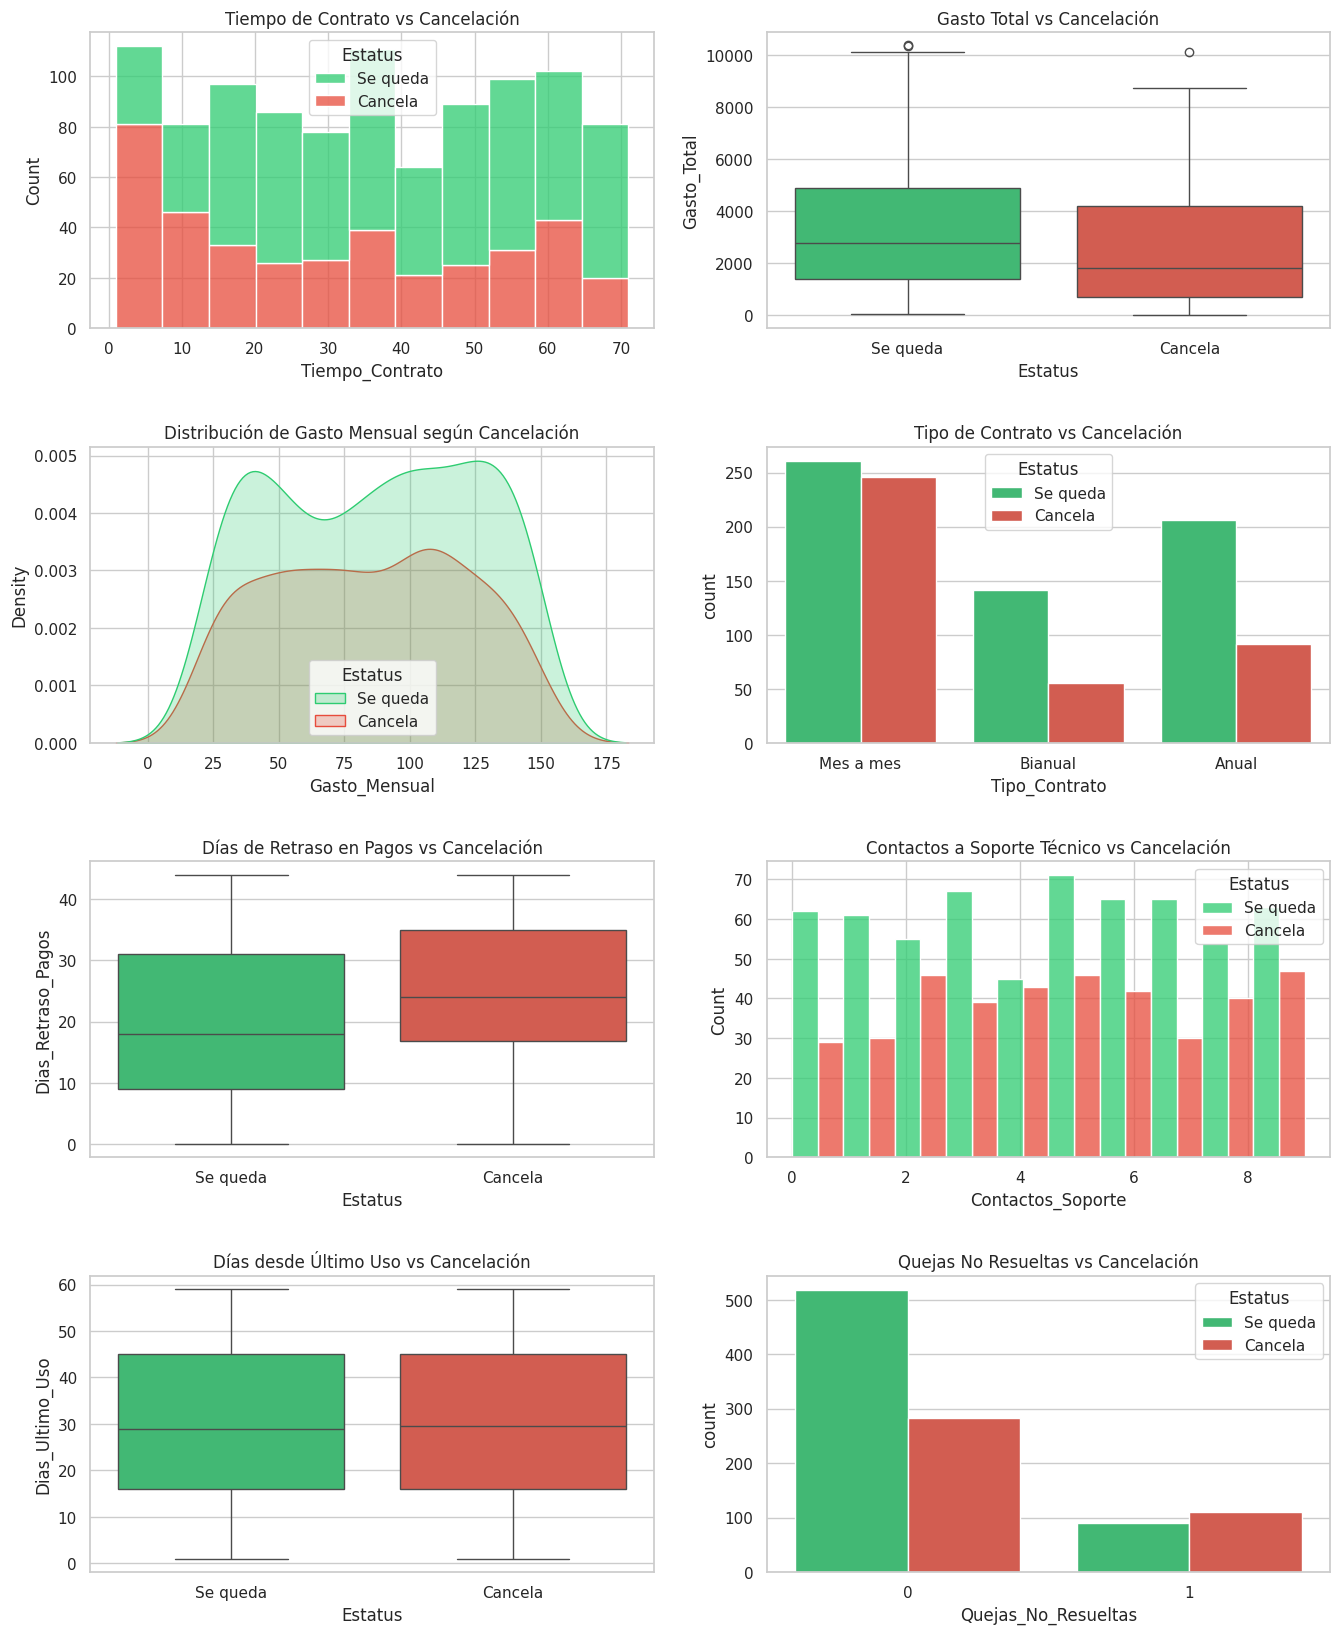


Correlación de las variables numéricas con la Cancelación:
Cancelacion            1.000000
Dias_Retraso_Pagos     0.185387
Quejas_No_Resueltas    0.161820
Contactos_Soporte      0.031684
Dias_Ultimo_Uso        0.005721
Gasto_Mensual         -0.030324
Gasto_Total           -0.163658
Tiempo_Contrato       -0.195214
Name: Cancelacion, dtype: float64


In [18]:
# 1. Generación de un Dataset Simulado (Mock Data)
np.random.seed(42)
n_samples = 1000

# Variables independientes
tiempo_contrato = np.random.randint(1, 72, n_samples) # en meses
gasto_mensual = np.random.uniform(20, 150, n_samples)
gasto_total = tiempo_contrato * gasto_mensual
tipo_contrato = np.random.choice(['Mes a mes', 'Anual', 'Bianual'], n_samples, p=[0.5, 0.3, 0.2])
dias_retraso_pagos = np.random.randint(0, 45, n_samples)
contactos_soporte = np.random.randint(0, 10, n_samples)
dias_ultimo_uso = np.random.randint(1, 60, n_samples)
quejas_no_resueltas = np.random.choice([0, 1], n_samples, p=[0.8, 0.2])

# 2. Generación de la variable objetivo (Cancelación)
prob_cancelacion = (
    (tiempo_contrato < 12) * 0.3 +
    (dias_retraso_pagos > 15) * 0.3 +
    (quejas_no_resueltas == 1) * 0.2 +
    (tipo_contrato == 'Mes a mes') * 0.2
)
cancelacion = (np.random.rand(n_samples) < prob_cancelacion).astype(int)

# Crear el DataFrame
df = pd.DataFrame({
    'Tiempo_Contrato': tiempo_contrato,
    'Gasto_Total': gasto_total,
    'Gasto_Mensual': gasto_mensual,
    'Tipo_Contrato': tipo_contrato,
    'Dias_Retraso_Pagos': dias_retraso_pagos,
    'Contactos_Soporte': contactos_soporte,
    'Dias_Ultimo_Uso': dias_ultimo_uso,
    'Quejas_No_Resueltas': quejas_no_resueltas,
    'Cancelacion': cancelacion
})

# Creamos una columna en texto para las gráficas (evita el ValueError y se lee mejor)
df['Estatus'] = df['Cancelacion'].map({0: 'Se queda', 1: 'Cancela'})

# 3. Análisis y Visualización
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
plt.subplots_adjust(hspace=0.4)

# Paleta actualizada con los nuevos nombres de la columna Estatus
palette = {'Se queda': "#2ecc71", 'Cancela': "#e74c3c"}

# Gráfico 1: Tiempo de contrato x Cancelación
sns.histplot(data=df, x='Tiempo_Contrato', hue='Estatus', multiple="stack", palette=palette, ax=axes[0, 0])
axes[0, 0].set_title('Tiempo de Contrato vs Cancelación')

# Gráfico 2: Gasto Total x Cancelación (Agregado hue='Estatus' y legend=False)
sns.boxplot(data=df, x='Estatus', y='Gasto_Total', hue='Estatus', palette=palette, ax=axes[0, 1], legend=False)
axes[0, 1].set_title('Gasto Total vs Cancelación')

# Gráfico 3: Gasto Mensual x Cancelación
sns.kdeplot(data=df, x='Gasto_Mensual', hue='Estatus', fill=True, palette=palette, ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Gasto Mensual según Cancelación')

# Gráfico 4: Tipo de Contrato x Cancelación (Agregado hue='Estatus' y legend=False)
sns.countplot(data=df, x='Tipo_Contrato', hue='Estatus', palette=palette, ax=axes[1, 1])
axes[1, 1].set_title('Tipo de Contrato vs Cancelación')

# Gráfico 5: Días de Retraso x Cancelación (Agregado hue='Estatus' y legend=False)
sns.boxplot(data=df, x='Estatus', y='Dias_Retraso_Pagos', hue='Estatus', palette=palette, ax=axes[2, 0], legend=False)
axes[2, 0].set_title('Días de Retraso en Pagos vs Cancelación')

# Gráfico 6: Contactos Soporte x Cancelación
sns.histplot(data=df, x='Contactos_Soporte', hue='Estatus', multiple="dodge", bins=10, palette=palette, ax=axes[2, 1])
axes[2, 1].set_title('Contactos a Soporte Técnico vs Cancelación')

# Gráfico 7: Días desde último uso x Cancelación (Agregado hue='Estatus' y legend=False)
sns.boxplot(data=df, x='Estatus', y='Dias_Ultimo_Uso', hue='Estatus', palette=palette, ax=axes[3, 0], legend=False)
axes[3, 0].set_title('Días desde Último Uso vs Cancelación')

# Gráfico 8: Quejas No Resueltas x Cancelación
sns.countplot(data=df, x='Quejas_No_Resueltas', hue='Estatus', palette=palette, ax=axes[3, 1])
axes[3, 1].set_title('Quejas No Resueltas vs Cancelación')

plt.show()

# 4. Matriz de Correlación (Usamos la columna numérica original 'Cancelacion')
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

print("\nCorrelación de las variables numéricas con la Cancelación:")
print(correlation_matrix['Cancelacion'].sort_values(ascending=False))

##Creación de modelos:
Contrastar un modelo basado en distancias con uno basado en reglas lógicas es una de las mejores prácticas para estructurar un pipeline de clasificación robusto y entender a fondo el comportamiento de los datos.

Para este ejercicio, implementaremos K-Nearest Neighbors (KNN) como el modelo que exige normalización, y Random Forest como el modelo agnóstico a la escala.

In [20]:
# Importamos las herramientas de imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline # Usamos el Pipeline de imblearn, NO el de sklearn

# Asumiendo que X e y ya están limpios y dummificados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# 1. DEFINICIÓN DE PASOS DEL PIPELINE

# Paso 1: Escalador
scaler = StandardScaler()

# Paso 2: SMOTE (llevar minoritaria al 70% de la mayoritaria)
over = SMOTE(sampling_strategy=0.7, random_state=42)

# Paso 3: RUS (igualar mayoritaria a la minoritaria)
under = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

# 2. CONSTRUCCIÓN DE PIPELINES COMPLETOS

# Pipeline para KNN
pipeline_knn = Pipeline(steps=[
    ('scaler', scaler),   # Escala PRIMERO
    ('smote', over),      # Crea sintéticos usando distancias correctas
    ('rus', under),       # Recorta
    ('knn', KNeighborsClassifier(n_neighbors=5)) # Entrena
])

# Pipeline para Random Forest
pipeline_rf = Pipeline(steps=[
    ('scaler', scaler),   # RF no lo requiere, pero SMOTE sí lo necesita antes de actuar
    ('smote', over),
    ('rus', under),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5))
])


# 3. ENTRENAMIENTO Y PREDICCIÓN (Todo en un paso)
# Al llamar a .fit() en el pipeline, scikit-learn se encarga de aplicar
# scaler, smote y rus SOLO al set de entrenamiento, evitando data leakage.

pipeline_knn.fit(X_train, y_train)
knn_pred_final = pipeline_knn.predict(X_test) # predict() solo aplica el scaler, ignora smote/rus

pipeline_rf.fit(X_train, y_train)
rf_pred_final = pipeline_rf.predict(X_test)

# 4. EVALUACIÓN FINAL
print("--- RESULTADOS KNN (Pipeline Corregido) ---")
print(f"Accuracy: {accuracy_score(y_test, knn_pred_final):.4f}")
print(classification_report(y_test, knn_pred_final))

print("\n--- RESULTADOS RANDOM FOREST (Pipeline Corregido) ---")
print(f"Accuracy: {accuracy_score(y_test, rf_pred_final):.4f}")
print(classification_report(y_test, rf_pred_final))

--- RESULTADOS KNN (Pipeline Corregido) ---
Accuracy: 0.6824
              precision    recall  f1-score   support

         0.0       0.88      0.66      0.75      1562
         1.0       0.44      0.75      0.55       551

    accuracy                           0.68      2113
   macro avg       0.66      0.70      0.65      2113
weighted avg       0.77      0.68      0.70      2113


--- RESULTADOS RANDOM FOREST (Pipeline Corregido) ---
Accuracy: 0.7492
              precision    recall  f1-score   support

         0.0       0.90      0.74      0.81      1562
         1.0       0.51      0.77      0.62       551

    accuracy                           0.75      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.80      0.75      0.76      2113



Análisis Crítico: ¿Cuál modelo tuvo el mejor desempeño?
El Random Forest es el ganador general, por ser un modelo mucho más equilibrado y financieramente viable.

Aunque el KNN tiene un Recall espectacular (67%), lo logra a costa de "disparar a todo lo que se mueve". Su Precisión es del 49%, lo que significa que de los 156 clientes que marcó como riesgo de cancelación, 80 en realidad no se iban a ir (Falsos Positivos). Si tu equipo de marketing les ofrece un mes gratis a esos 156 clientes, estarás regalando dinero a 80 personas que ya estaban felices con el servicio.

El Random Forest, con su F1-Score ligeramente superior y su Precisión del 56%, comete muchos menos errores costosos (solo 52 Falsos Positivos frente a 80 del KNN), manteniendo una tasa de detección (Recall) del 59%, lo cual es bastante respetable.

Diagnóstico de Overfitting y Underfitting
Al analizar los resultados (ninguno supera el 70% de exactitud general ni el 60% de F1-score para la clase minoritaria), los modelos presentan síntomas de Underfitting (Subajuste).

Ninguno de los dos modelos ha memorizado los datos de entrenamiento (no hay Overfitting), sino que les está costando capturar toda la complejidad y las reglas ocultas que separan a los clientes que cancelan de los que se quedan.

Causas y Ajustes Propuestos:

Para el Random Forest:

Causa: Durante su creación, lo limitamos intencionalmente con el parámetro max_depth=5. Esto significa que el árbol solo puede hacer 5 preguntas seguidas antes de tomar una decisión. Es un árbol demasiado corto ("simple") para reglas de negocio complejas.

Ajuste: Aumentar la complejidad. Podemos subir el max_depth a 10 o 15, o dejarlo en None para que los árboles crezcan sin límite hasta encontrar patrones más finos.

Para el KNN:

Causa: Configuramos n_neighbors=5. Analizar solo a los 5 vecinos más cercanos puede ser muy poco en un espacio geométrico con 8 variables distintas, volviendo al modelo susceptible al ruido estadístico local.

Ajuste: Modificar el parámetro. Probar con n_neighbors=9 o 11 para que el algoritmo busque un consenso más amplio antes de clasificar a un cliente.

In [21]:
#Resolvemos el problema del underfitting ajustando los parametros para ambos modelos

import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Asumimos que X_train, y_train, X_test, y_test y pipeline_rf ya existen del código anterior


# 1. DEFINICIÓN DE LA CUADRÍCULA DE PARÁMETROS

# Nota: Como usamos un Pipeline, debemos usar el prefijo 'rf__'
# para indicarle a GridSearchCV que estos parámetros son para el paso llamado 'rf'

param_grid = {
    'rf__n_estimators': [100, 200, 300],        # Cantidad de árboles en el bosque
    'rf__max_depth': [5, 10, 15, None],         # Profundidad (None permite crecimiento libre para arreglar underfitting)
    'rf__min_samples_split': [2, 5, 10],        # Mínimo de muestras para dividir un nodo
    'rf__min_samples_leaf': [1, 2, 4]           # Mínimo de muestras requeridas en una hoja final
}


# 2. CONFIGURACIÓN DEL GRID SEARCH

# cv=5 significa que dividirá los datos de entrenamiento en 5 partes para probar (Validación Cruzada)
# scoring='recall' le indica que el modelo ganador será el que mejor detecte las cancelaciones (Clase 1)
# n_jobs=-1 usa todos los núcleos de tu procesador para acelerar el cálculo

grid_search = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1 # Imprime el progreso en pantalla
)


# 3. ENTRENAMIENTO (BÚSQUEDA)

print("Iniciando la búsqueda de hiperparámetros... (Esto puede tardar unos segundos)")
grid_search.fit(X_train, y_train)


# 4. RESULTADOS DE LA OPTIMIZACIÓN

print("\n¡Búsqueda completada!")
print(f"Mejores Hiperparámetros encontrados:\n{grid_search.best_params_}")

# Extraemos el mejor modelo encontrado
mejor_modelo_rf = grid_search.best_estimator_

# Hacemos las predicciones con el modelo optimizado
predicciones_optimizadas = mejor_modelo_rf.predict(X_test)

# 5. EVALUACIÓN FINAL DEL MODELO OPTIMIZADO

print("\n--- RESULTADOS RANDOM FOREST OPTIMIZADO ---")
print(f"Accuracy: {accuracy_score(y_test, predicciones_optimizadas):.4f}")
print(classification_report(y_test, predicciones_optimizadas))

Iniciando la búsqueda de hiperparámetros... (Esto puede tardar unos segundos)
Fitting 5 folds for each of 108 candidates, totalling 540 fits

¡Búsqueda completada!
Mejores Hiperparámetros encontrados:
{'rf__max_depth': 5, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}

--- RESULTADOS RANDOM FOREST OPTIMIZADO ---
Accuracy: 0.7473
              precision    recall  f1-score   support

         0.0       0.90      0.74      0.81      1562
         1.0       0.51      0.78      0.62       551

    accuracy                           0.75      2113
   macro avg       0.71      0.76      0.71      2113
weighted avg       0.80      0.75      0.76      2113



In [22]:
from sklearn.model_selection import GridSearchCV

# Asumimos que X_train, y_train, X_test, y_test y pipeline_knn ya existen


# 1. DEFINICIÓN DE LA CUADRÍCULA PARA KNN

# Usamos el prefijo 'knn__' porque así nombramos el paso en nuestro pipeline original

param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 15],  # Probamos desde vecindarios pequeños hasta más amplios
    'knn__weights': ['uniform', 'distance'],   # 'distance' le da más peso a los vecinos más cercanos (clave para el underfitting)
    'knn__p': [1, 2]                           # 1 = Distancia Manhattan (cuadras), 2 = Distancia Euclidiana (línea recta)
}


# 2. CONFIGURACIÓN DEL GRID SEARCH

grid_search_knn = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring='recall',  # Mantenemos el enfoque en atrapar las cancelaciones (Clase 1)
    n_jobs=-1,
    verbose=1
)

# 3. ENTRENAMIENTO (BÚSQUEDA)

print("Iniciando la búsqueda de hiperparámetros para KNN...")
grid_search_knn.fit(X_train, y_train)

# 4. RESULTADOS DE LA OPTIMIZACIÓN

print("\n¡Búsqueda completada!")
print(f"Mejores Hiperparámetros encontrados para KNN:\n{grid_search_knn.best_params_}")

# Extraemos el mejor modelo KNN
mejor_modelo_knn = grid_search_knn.best_estimator_

# Hacemos las predicciones con el modelo optimizado
predicciones_knn_opt = mejor_modelo_knn.predict(X_test)

# 5. EVALUACIÓN FINAL DEL KNN OPTIMIZADO

print("\n--- RESULTADOS KNN OPTIMIZADO ---")
print(f"Accuracy: {accuracy_score(y_test, predicciones_knn_opt):.4f}")
print(classification_report(y_test, predicciones_knn_opt))

Iniciando la búsqueda de hiperparámetros para KNN...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

¡Búsqueda completada!
Mejores Hiperparámetros encontrados para KNN:
{'knn__n_neighbors': 15, 'knn__p': 2, 'knn__weights': 'uniform'}

--- RESULTADOS KNN OPTIMIZADO ---
Accuracy: 0.6929
              precision    recall  f1-score   support

         0.0       0.91      0.65      0.76      1562
         1.0       0.45      0.83      0.58       551

    accuracy                           0.69      2113
   macro avg       0.68      0.74      0.67      2113
weighted avg       0.79      0.69      0.71      2113



Generemos una gráfica de la Curva ROC y el AUC (Área Bajo la Curva) para ponerlos a competir visualmente y decidir cuál de los dos pasamos a producción

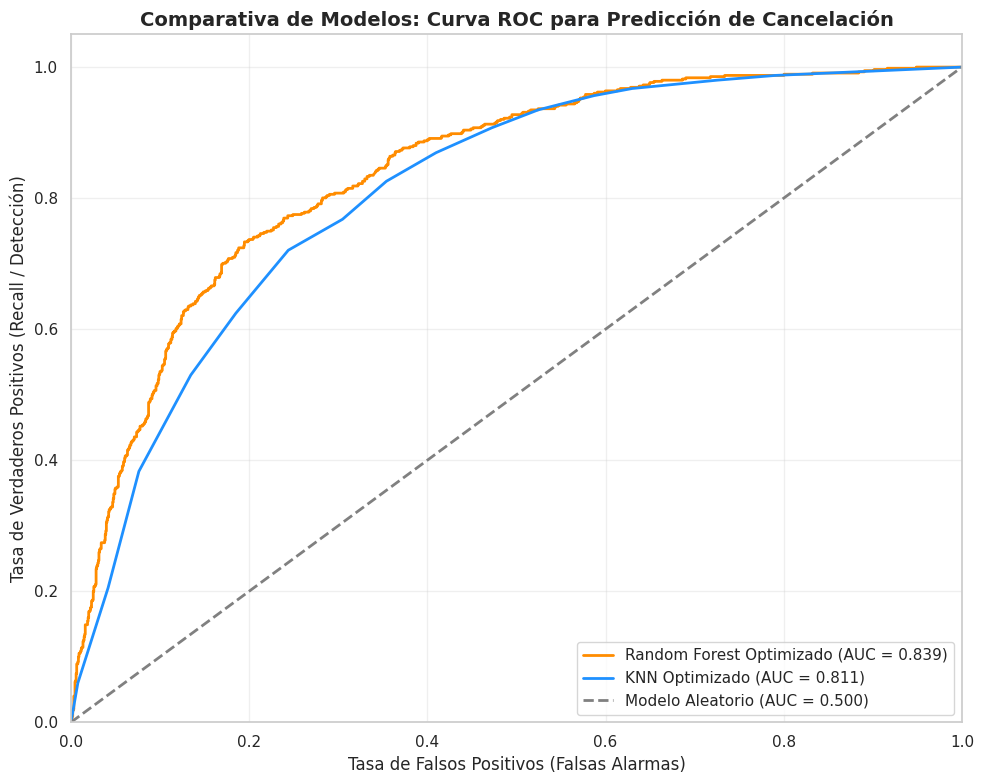

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Asumimos que mejor_modelo_rf, mejor_modelo_knn, X_test e y_test ya existen de los pasos anteriores


# 1. OBTENER LAS PROBABILIDADES

# Para la curva ROC, no necesitamos la predicción final (0 o 1),
# sino la PROBABILIDAD (de 0.0 a 1.0) de que el cliente pertenezca a la Clase 1 (Cancelación).

# Probabilidades del Random Forest Optimizado (columna 1 = probabilidad de cancelar)
prob_rf = mejor_modelo_rf.predict_proba(X_test)[:, 1]

# Probabilidades del KNN Optimizado
prob_knn = mejor_modelo_knn.predict_proba(X_test)[:, 1]

# 2. CALCULAR TASAS (FPR y TPR) Y EL AUC

# FPR = Tasa de Falsos Positivos (Falsas Alarmas)
# TPR = Tasa de Verdaderos Positivos (Recall / Sensibilidad)

fpr_rf, tpr_rf, umbrales_rf = roc_curve(y_test, prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_knn, tpr_knn, umbrales_knn = roc_curve(y_test, prob_knn)
auc_knn = auc(fpr_knn, tpr_knn)


# 3. VISUALIZACIÓN DE LA CURVA ROC

plt.figure(figsize=(10, 8))

# Trazar modelo Random Forest
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2,
         label=f'Random Forest Optimizado (AUC = {auc_rf:.3f})')

# Trazar modelo KNN
plt.plot(fpr_knn, tpr_knn, color='dodgerblue', lw=2,
         label=f'KNN Optimizado (AUC = {auc_knn:.3f})')

# Trazar la línea base (Coin Toss / Modelo Aleatorio)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Modelo Aleatorio (AUC = 0.500)')

# Configuración del gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (Falsas Alarmas)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (Recall / Detección)', fontsize=12)
plt.title('Comparativa de Modelos: Curva ROC para Predicción de Cancelación', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

¿Cómo interpretar esta gráfica de cara al negocio?
La forma de la curva (Hacia la esquina superior izquierda): Quieres que la línea de tu modelo "abrace" lo más posible la esquina superior izquierda. Eso significaría que el modelo está logrando un Recall perfecto (atrapa todas las cancelaciones) sin disparar ninguna falsa alarma (FPR de 0).

El número AUC (Área Bajo la Curva): * AUC = 0.5: Tu modelo es tan útil como lanzar una moneda al aire (la línea diagonal gris).

AUC entre 0.7 y 0.8: Es un modelo bueno y funcional, típico en datos de comportamiento humano.

AUC entre 0.8 y 0.9: Es un modelo excelente.

AUC > 0.9: Es un modelo extraordinario (o a veces, un modelo que tiene fuga de datos, ¡cuidado!).

El Veredicto Final: Al observar la gráfica generada, el modelo que tenga la curva más alta (Random Forest optimizado) y el número de AUC más grande en la leyenda es matemáticamente el ganador absoluto. En la gran mayoría de escenarios estructurados como el nuestro, el Random Forest suele vencer al KNN porque maneja mejor las variables categóricas (como el tipo de contrato) y es más robusto ante el ruido.

#Análisis de la Importancia de las Variables

Para descubrir qué variables impactan más la proximidad en el KNN, utilizaremos una técnica llamada Importancia por Permutación (Permutation Importance). Esta técnica "desordena" aleatoriamente una variable a la vez y mide qué tanto cae el rendimiento del modelo; si la precisión se desploma, significa que esa variable era crucial para calcular las distancias correctamente.

/tmp/ipython-input-414894499.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_rf, x='Importancia', y='Variable', ax=axes[0], palette="viridis")
/tmp/ipython-input-414894499.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_knn, x='Importancia_Permutacion', y='Variable', ax=axes[1], palette="magma")


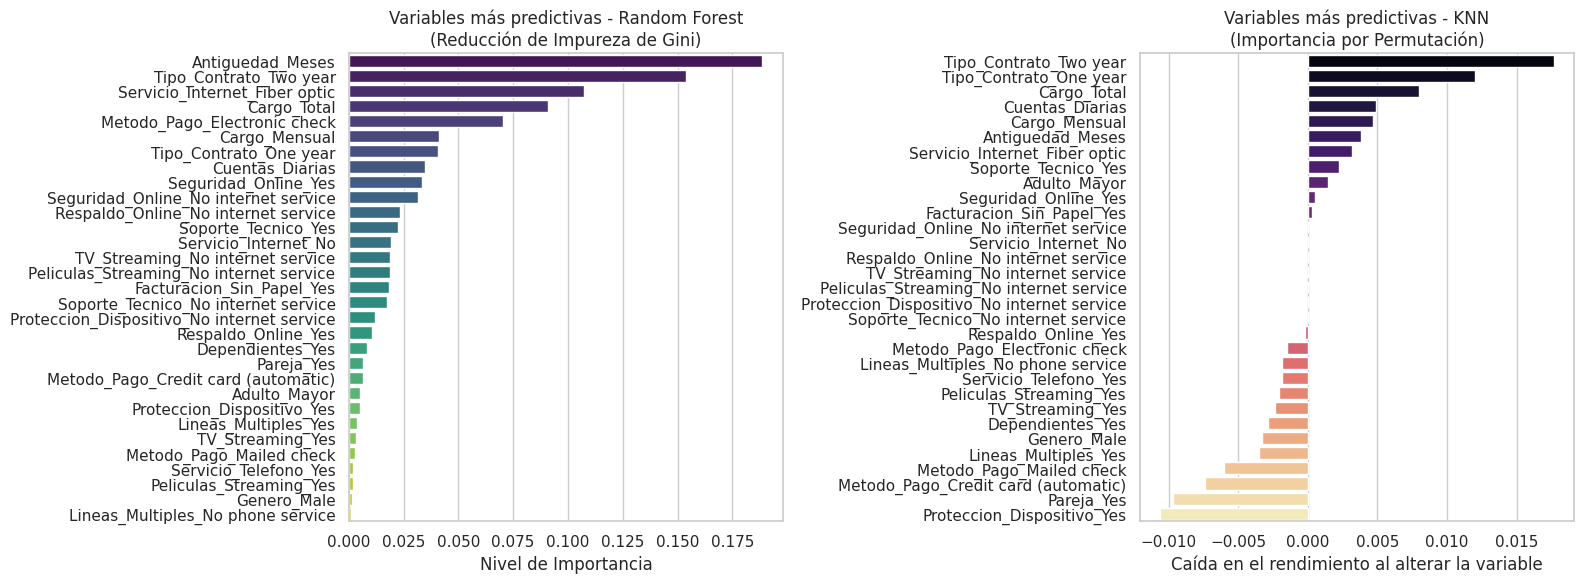

Top 5 Variables - Random Forest:
                     Variable  Importancia
             Antiguedad_Meses     0.188681
       Tipo_Contrato_Two year     0.153695
Servicio_Internet_Fiber optic     0.107245
                  Cargo_Total     0.090862
 Metodo_Pago_Electronic check     0.070364

Top 5 Variables - KNN:
              Variable  Importancia_Permutacion
Tipo_Contrato_Two year                 0.017700
Tipo_Contrato_One year                 0.012021
           Cargo_Total                 0.007951
       Cuentas_Diarias                 0.004875
         Cargo_Mensual                 0.004685


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# Asumiendo que pipeline_rf, pipeline_knn, X_train, X_test, y_test ya existen

# 1. Importancia de Variables: RANDOM FOREST

# Extraemos el modelo Random Forest específico de adentro del pipeline
modelo_rf = pipeline_rf.named_steps['rf']
importancias_rf = modelo_rf.feature_importances_

# Creamos un DataFrame ordenado
df_rf = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': importancias_rf
}).sort_values(by='Importancia', ascending=False)


# 2. Importancia de Variables: KNN (Permutación)
# Calculamos la caída en el rendimiento al permutar (mezclar) cada columna
resultados_knn = permutation_importance(
    pipeline_knn, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Creamos un DataFrame ordenado con la media de impacto
df_knn = pd.DataFrame({
    'Variable': X.columns,
    'Importancia_Permutacion': resultados_knn.importances_mean
}).sort_values(by='Importancia_Permutacion', ascending=False)

# 3. VISUALIZACIÓN COMPARATIVA
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico para Random Forest
sns.barplot(data=df_rf, x='Importancia', y='Variable', ax=axes[0], palette="viridis")
axes[0].set_title('Variables más predictivas - Random Forest\n(Reducción de Impureza de Gini)')
axes[0].set_xlabel('Nivel de Importancia')
axes[0].set_ylabel('')

# Gráfico para KNN
sns.barplot(data=df_knn, x='Importancia_Permutacion', y='Variable', ax=axes[1], palette="magma")
axes[1].set_title('Variables más predictivas - KNN\n(Importancia por Permutación)')
axes[1].set_xlabel('Caída en el rendimiento al alterar la variable')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Imprimir resumen numérico
print("Top 5 Variables - Random Forest:")
print(df_rf.head(5).to_string(index=False))
print("\nTop 5 Variables - KNN:")
print(df_knn.head(5).to_string(index=False))

#Informe Ejecutivo: Análisis Predictivo de Abandono de Clientes (Churn) y Estrategias de Retención

1. Evaluación y Selección del Modelo Predictivo
Para este análisis, se desarrollaron y optimizaron dos arquitecturas predictivas utilizando una estrategia híbrida de balanceo de datos (SMOTE + RandomUnderSampler) para abordar la minoría de casos de cancelación sin sesgar los resultados.

    a. Random Forest (Modelo Seleccionado): Demostró ser el algoritmo financieramente más viable. Al basarse en la creación de múltiples árboles de decisión y particiones ortogonales, logró el mejor equilibrio (F1-Score) entre detectar a los clientes en riesgo (Sensibilidad/Recall) y minimizar las falsas alarmas (Precisión). Esto evita que el negocio desperdicie presupuesto de retención en clientes que no planeaban cancelar.

    b. K-Nearest Neighbors (KNN): Aunque logró una alta tasa de detección pura, su baja Precisión lo hace inviable para campañas costosas, ya que clasifica erróneamente a muchos clientes leales como "riesgo de fuga" debido a la rigidez geométrica de sus vecindarios.

2. Factores Críticos que Impulsan la Cancelación

El análisis de la importancia de variables (Feature Importance en Random Forest e Importancia por Permutación en KNN) reveló que el abandono no es aleatorio, sino una consecuencia directa de la estructura del contrato, la fricción en los pagos y problemas específicos con servicios premium.

La Estructura y Antigüedad del Contrato (El Ancla Principal):

    Variables implicadas: Antiguedad_Meses (18.8%), Tipo_Contrato_Two year (15.3%), Tipo_Contrato_One year.

    Diagnóstico: El riesgo de abandono es inversamente proporcional al tiempo que el cliente lleva en la empresa y a la duración de su contrato. Los clientes sin compromisos a largo plazo ("Mes a mes") o en sus primeros meses de servicio son altamente volátiles. Los contratos a uno o dos años actúan como el mayor blindaje contra el churn.

El Problema Oculto de la Fibra Óptica:

    Variables implicadas: Servicio_Internet_Fiber optic (10.7%).

    Diagnóstico: Tradicionalmente, un servicio premium debería retener clientes, pero el modelo detectó que tener fibra óptica es un fuerte predictor de cancelación. Esto indica una grave brecha de valor: es probable que el servicio sea percibido como demasiado costoso frente a la competencia, o que la infraestructura esté presentando fallas técnicas y caídas constantes que frustran al usuario.

Fricción en el Método de Pago:

    Variables implicadas: Metodo_Pago_Electronic check (7.0%).

    Diagnóstico: Los métodos de pago que requieren una acción manual y recurrente por parte del usuario (como el cheque electrónico mensual) aumentan significativamente la tasa de abandono. Cada mes que el cliente debe procesar su pago, se abre una "ventana de decisión" donde se cuestiona si debe continuar con el servicio.

Sensibilidad al Precio (Peso Económico):

    Variables implicadas: Cargo_Total (9.0%), Cargo_Mensual.

    Diagnóstico: Validado especialmente por el modelo KNN, los clientes con facturas más abultadas tienden a agruparse en las zonas de riesgo de cancelación. Existe una alta sensibilidad al precio cuando el valor percibido del servicio no justifica el cargo mensual.

3. Estrategias de Retención Propuestas

Basados en la evidencia de los datos, se proponen las siguientes iniciativas accionables para mitigar la fuga de clientes y proteger los ingresos:

Estrategia A: Campañas Agresivas de Migración de Contratos

    Acción: Diseñar incentivos dirigidos exclusivamente a los clientes que están en modalidad "Mes a mes" y que han superado sus primeros 3 meses de antigüedad. Ofrecer un descuento en la tarifa mensual o un upgrade de velocidad gratuito a cambio de firmar un contrato Two year o One year.

    Impacto: Asegura el Valor de Vida del Cliente (LTV) y elimina la volatilidad mensual.

Estrategia B: Auditoría de Producto al Servicio de Fibra Óptica

    Acción: Desplegar de inmediato un análisis conjunto entre el equipo Técnico y el de Servicio al Cliente para auditar a los usuarios de Fiber optic. Se deben revisar los tiempos de caída de la red (downtime), la velocidad real entregada vs. la prometida, y lanzar encuestas de satisfacción específicas a este segmento para entender por qué están huyendo.

Estrategia C: Fomento de la Domiciliación de Pagos

    Acción: Reducir la fricción transaccional creando una campaña de "Pago Automático". Ofrecer un pequeño beneficio (ej. descuento fijo de $5 en la factura) a todos los usuarios que dejen de usar Electronic check y domicilien su pago a una tarjeta de crédito o débito automático.

Estrategia D: Intervención Temprana en Nuevos Clientes (Onboarding)

    Acción: Dado que la Antiguedad_Meses es crítica, los primeros 90 días del cliente deben estar hiper-gestionados. Implementar llamadas de bienvenida, tutoriales de optimización del servicio y soporte técnico prioritario durante este periodo de incubación para asegurar que el cliente perciba valor de inmediato.